# Quantum Machine Learning and MPS
Let's look at the Tree Tensor Network as a model for quantum machine learning.

## What you will learn
1. MPS model
2. Optimization

## Install Blueqat

In [ ]:
!pip install blueqat

The model we are going to build is called TTN. The quantum circuit is as follows.

<img src="../tutorial-ja/img/254_img.png" width="25%">

It has a shape that takes on tree structure.  
This circuit uses a one qubit arbitrary rotation gate (a combination of $Rz$ and $Ry$ gates) and a two qubit gate ($CX$ gate).  
More details are as follows.

<img src="../tutorial-ja/img/253_img_2.png" width="35%">

In [2]:
from blueqat import Circuit
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

Configure hyperparameters and other settings.

In [13]:
np.random.seed(45)

# Number of steps of optimizetaion
nsteps = 5000

# Number of parameters of the quantum circuit to be optimized
nparams = 18

# Fineness of numerical differentiation
h = 0.01

# Learning rate
e = 0.01

# Initial parameter
param_init = [np.random.rand() * np.pi * 2 for i in range(nparams)]

# list for containing results
arr = []

# 1: train, 2: prediction
mode = 1

In [14]:
def mpsZ(a, ran, mode=1):
    
    # Input circuit
    init = [Circuit(4).x[0,1], Circuit(4).x[2,3], Circuit(4).x[0], Circuit(4).x[1], Circuit(4).x[2], Circuit(4).x[0,2]]
    # Target label
    target = [1, 1, -1, -1, -1, 1]
   
    # Circuit construction
    u = init[ran]
    u.rx(a[0])[0].ry(a[1])[0].rz(a[2])[0]
    u.rx(a[3])[1].ry(a[4])[1].rz(a[5])[1]    
    u.rx(a[6])[2].ry(a[7])[2].rz(a[8])[2]
    u.rz(a[9])[3].ry(a[10])[3].rz(a[11])[3]
    u.cx[0,1]
    u.rz(a[12])[1].ry(a[13])[1].rz(a[14])[1]
    u.cx[1,2]
    u.rz(a[15])[2].ry(a[16])[2].rz(a[17])[2]
    u.cx[2,3]
    
    # Calculate expectation value from state vector
    full = u.run()
    expt = sum(np.abs(full[:8])**2) - sum(np.abs(full[8:])**2)
    
    if(mode ==1):
        # return error between label and prediction
        return (expt - target[ran]) ** 2
    else:
        return expt

Stochastic gradient descent (SGD) is used to learning.
At the start of each step, the input data is randomly selected from 6 ways (0 to 5), and the gradient is calculated and the parameters are updated.

In each step, the gradient calculation and parameter update are performed on only one data, but by repeating the process while randomly selecting input data, the system eventually learns to minimize the loss function for all data.

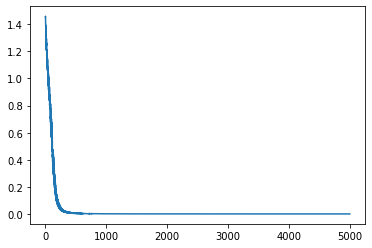

55.52810287475586


In [15]:
start = time.time()

param = param_init.copy()

for i in range(nsteps):
    it = np.random.randint(0,6)
    
    loss = mpsZ(param, it)
    arr.append(loss)
    param_new = [0 for i in range(nparams)]
    
    for j in range(nparams):
        _param = param.copy()
        _param[j] += h
        param_new[j] = param[j] - e*(mpsZ(_param, it) - loss) / h

    param = param_new

plt.plot(arr)
plt.show()
print(time.time() - start)

It converged well.  
Let's check it out.

In [16]:
target = [1,1,-1,-1,-1,1]
preds = []
for i in range(6):
    pred = mpsZ(param, i, mode=2)
    preds.append(pred)
    print("Prediction :", pred, "        Target :", target[i])

Prediction : 0.9948310051705295         Target : 1
Prediction : 0.9940603430467222         Target : 1
Prediction : -0.9952916161147218         Target : -1
Prediction : -0.9945209539909148         Target : -1
Prediction : -0.9940603430467226         Target : -1
Prediction : 0.995291616114722         Target : 1


From the above, we were able to learn a quantum circuit using the MPS model.